<a href="https://colab.research.google.com/github/datasith/ML-Notebooks-TensorFlow/blob/main/Object_Detection_YOLO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using Single-Stage Detectors (YOLO)

In this notebook I provide a short introduction and overview of the process involved in building a **Convolutional Neural Network** (CNN) in **TensorFlow** using the **YOLO** network architecture for the task of Object Detection.

Object Detection is a computer vision technique for locating instances of objects in images or videos, and it typically involves Deep Learning architectures. One such type of architecture is the Single-Stage Detector, and **YOLO** is one of its most popular implementations.

The code below shows how to build the model from scratch — albeit with the help of a config file for setting up the 192-layer architecture — and how to set it up for localizing objects using weights from a model trained on the **COCO dataset**.

---
**Author:** Cisco Zabala ([@datasith](https://twitter.com/datasith) | [LinkedIn](https://www.linkedin.com/in/datasith/) | [Kaggle](https://kaggle.com/thedatasith) | [GitHub](https://github.com/datasith))

## Background

The objective for Object Detection is to localize one or multiple object(s) in an image, in addition to determining what that object is. In other words, it's a combination of [Image Classification](https://colab.research.google.com/github/datasith/ML-Notebooks-TensorFlow/blob/main/Image_Classification_AlexNet.ipynb) and [Object Localization](http://cs231n.stanford.edu/).


![](https://github.com/datasith/ML-Notebooks-TensorFlow/blob/main/img/Object_Detection_YOLOv3/cv-tasks.jpg?raw=true)

- Image Classification
    - Determine the label for an object in an image (e.g., cat, bicycle, person)
    - **Input**: An image with one or more objects, such as a photograph
    - **Output**: A vector of probabilities (softmax) or one-hot encoding (argmax) indicating the class(es) of the object(s) in the image

- Object Localization
    - Locate the presence of objects in an image and indicate their location with a bounding box
    - **Input**: An image with one or more objects, such as a photograph
    - **Output**: One or more bounding boxes (e.g. defined by a point, width, and height)

- **Object Detection**
    - Locate the presence of objects with a bounding box and types or classes of the located objects in an image
    - **Input**: An image with one or more objects, such as a photograph
    - **Output**: One or more bounding boxes (e.g. defined by a point, width, and height), and a class label for each bounding box

**YOLO** is an Object Detection algorithm, which was a breakthrough in the field of Deep Learning applied to Computer Vision when first released by [Joseph Redmon in 2015](https://arxiv.org/abs/1506.02640).

![]()

[You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640)...


---

* []()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import time

from tensorflow.keras import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, \
    Input, ZeroPadding2D, LeakyReLU, UpSampling2D

## Prepare the dataset (Kaggle)

To use the Kaggle API, sign up for a Kaggle account at https://www.kaggle.com. Then go to the 'Account' tab of your user profile (`https://www.kaggle.com/<username>/account`) and select 'Create API Token'. This will trigger the download of `kaggle.json`, a file containing your API credentials. Place this file in the location `~/.kaggle/kaggle.json`

For protection, remember to modify read-write access to the file:

```chmod 600 ~/.kaggle/kaggle.json```

In [ ]:
# In case the Kaggle CLI isn't installed already

# !pip install kaggle > /dev/null

In [ ]:
# Replace the values to match your username and API key if you haven't added the file already

!mkdir -p ~/.kaggle
!echo "{\"username\":\"thedatasith\",\"key\":\"03dbc75ae6d3d8533bca0bcc4b040baa\"}" > ~/.kaggle/kaggle.json && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!mkdir -p config dataset
# !wget https://raw.githubusercontent.com/pjreddie/darknet/master/cfg/yolov3.cfg -P config  -q
# !wget https://pjreddie.com/media/files/yolov3.weights -P weights -q
# !wget https://github.com/pjreddie/darknet/blob/master/data/coco.names -P dataset -q

# Specify the location of the dataset for the CLI
# thedatasith/yolov3

DATASET_OWNER = "thedatasith"
DATASET_NAME  = "yolov3"
!kaggle datasets download "$DATASET_NAME" 
!unzip yolov3.zip && rm yolov3.zip
!mv yolov3.weights weights
!mv yolov3.cfg config
!mv coco.names dataset

 97% 213M/220M [00:02<00:00, 75.0MB/s]
100% 220M/220M [00:02<00:00, 93.2MB/s]
Archive:  yolov3.zip
  inflating: coco.names              
  inflating: yolov3.cfg              
  inflating: yolov3.weights/yolov3.weights  


In [ ]:
cfgfile = "config/yolov3.cfg"
weightfile = "weights/yolov3.weights"

In [ ]:
def parse_cfg(cfgfile):
    with open(cfgfile, 'r') as file:
        lines = [line.rstrip('\n') for line in file if line != '\n' and line[0] != '#']
    holder = {}
    blocks = []
    for line in lines:
        if line[0] == '[':
            line = 'type=' + line[1:-1].rstrip()
            if len(holder) != 0:
                blocks.append(holder)
                holder = {}
        key, value = line.split("=")
        holder[key.rstrip()] = value.lstrip()
    blocks.append(holder)
    return blocks

blocks = parse_cfg(cfgfile)

In [ ]:
model_size = (416, 416, 3)
num_classes = 80

In [ ]:
blocks = parse_cfg(cfgfile)

outputs = {}
output_filters = []
filters = []
out_pred = []
scale = 0

inputs = input_image = Input(shape=model_size)
inputs = inputs / 255.0

for i, block in enumerate(blocks[1:]):
    # If it is a convolutional layer
    if (block["type"] == "convolutional"):

        activation = block["activation"]
        filters = int(block["filters"])
        kernel_size = int(block["size"])
        strides = int(block["stride"])

        if strides > 1:
            inputs = ZeroPadding2D(((1, 0), (1, 0)))(inputs)

        inputs = Conv2D(filters,
                        kernel_size,
                        strides=strides,
                        padding='valid' if strides > 1 else 'same',
                        name='conv_' + str(i),
                        use_bias=False if ("batch_normalize" in block) else True)(inputs)

        if "batch_normalize" in block:
            inputs = BatchNormalization(name='bnorm_' + str(i))(inputs)
        if activation == "leaky":
            inputs = LeakyReLU(alpha=0.1, name='leaky_' + str(i))(inputs)

    elif (block["type"] == "upsample"):
        stride = int(block["stride"])
        inputs = UpSampling2D(stride)(inputs)

    # If it is a route layer
    elif (block["type"] == "route"):
        block["layers"] = block["layers"].split(',')
        start = int(block["layers"][0])

        if len(block["layers"]) > 1:
            end = int(block["layers"][1]) - i
            filters = output_filters[i + start] + output_filters[end]  # Index negatif :end - index
            inputs = tf.concat([outputs[i + start], outputs[i + end]], axis=-1)
        else:
            filters = output_filters[i + start]
            inputs = outputs[i + start]

    elif block["type"] == "shortcut":
        from_ = int(block["from"])
        inputs = outputs[i - 1] + outputs[i + from_]

    # Yolo detection layer
    elif block["type"] == "yolo":

        mask = block["mask"].split(",")
        mask = [int(x) for x in mask]
        anchors = block["anchors"].split(",")
        anchors = [int(a) for a in anchors]
        anchors = [(anchors[i], anchors[i + 1]) for i in range(0, len(anchors), 2)]
        anchors = [anchors[i] for i in mask]

        n_anchors = len(anchors)

        out_shape = inputs.get_shape().as_list()

        inputs = tf.reshape(inputs, [-1, n_anchors * out_shape[1] * out_shape[2], \
                  5 + num_classes])

        box_centers = inputs[:, :, 0:2]
        box_shapes = inputs[:, :, 2:4]
        confidence = inputs[:, :, 4:5]
        classes = inputs[:, :, 5:num_classes + 5]

        box_centers = tf.sigmoid(box_centers)
        confidence = tf.sigmoid(confidence)
        classes = tf.sigmoid(classes)

        anchors = tf.tile(anchors, [out_shape[1] * out_shape[2], 1])
        box_shapes = tf.exp(box_shapes) * tf.cast(anchors, dtype=tf.float32)

        x = tf.range(out_shape[1], dtype=tf.float32)
        y = tf.range(out_shape[2], dtype=tf.float32)

        cx, cy = tf.meshgrid(x, y)
        cx = tf.reshape(cx, (-1, 1))
        cy = tf.reshape(cy, (-1, 1))
        cxy = tf.concat([cx, cy], axis=-1)
        cxy = tf.tile(cxy, [1, n_anchors])
        cxy = tf.reshape(cxy, [1, -1, 2])

        strides = (input_image.shape[1] // out_shape[1], \
                    input_image.shape[2] // out_shape[2])
        box_centers = (box_centers + cxy) * strides

        prediction = tf.concat([box_centers, box_shapes, confidence, classes], axis=-1)

        if scale:
            out_pred = tf.concat([out_pred, prediction], axis=1)
        else:
            out_pred = prediction
            scale = 1

    outputs[i] = inputs
    output_filters.append(filters)

model = Model(input_image, out_pred)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 416, 416, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv_0 (Conv2D)                (None, 416, 416, 32  864         ['tf.math.truediv[0][0]']        
                                )                                                                 
                                                                                              

In [ ]:
# Open the weights file
fp = open(weightfile, "rb")
# Skip 5 header values
np.fromfile(fp, dtype=np.int32, count=5)
# The rest of the values are the weights
blocks = parse_cfg(cfgfile)
for i, block in enumerate(blocks[1:]):
    if (block["type"] == "convolutional"):
        conv_layer = model.get_layer('conv_' + str(i))
        print("layer: ",i+1,conv_layer)
        filters = conv_layer.filters
        k_size = conv_layer.kernel_size[0]
        in_dim = conv_layer.input_shape[-1]
        if "batch_normalize" in block:
            norm_layer = model.get_layer('bnorm_' + str(i))
            print("layer: ",i+1,norm_layer)
            size = np.prod(norm_layer.get_weights()[0].shape)
            bn_weights = np.fromfile(fp, dtype=np.float32, count=4 * filters)
            # tf [gamma, beta, mean, variance]
            bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
        else:
            conv_bias = np.fromfile(fp, dtype=np.float32, count=filters)
        # darknet shape (out_dim, in_dim, height, width)
        conv_shape = (filters, in_dim, k_size, k_size)
        conv_weights = np.fromfile(
            fp, dtype=np.float32, count=np.product(conv_shape))
        # tf shape (height, width, in_dim, out_dim)
        conv_weights = conv_weights.reshape(
            conv_shape).transpose([2, 3, 1, 0])
        if "batch_normalize" in block:
            norm_layer.set_weights(bn_weights)
            conv_layer.set_weights([conv_weights])
        else:
            conv_layer.set_weights([conv_weights, conv_bias])
assert len(fp.read()) == 0, 'failed to read all data'
fp.close()

layer:  1 <keras.layers.convolutional.Conv2D object at 0x7f54d0bc9fd0>
layer:  1 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f54d0bb8690>
layer:  2 <keras.layers.convolutional.Conv2D object at 0x7f54d00cb810>
layer:  2 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f54d00cbe10>
layer:  3 <keras.layers.convolutional.Conv2D object at 0x7f54d00e2fd0>
layer:  3 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f54f23f5a10>
layer:  4 <keras.layers.convolutional.Conv2D object at 0x7f54d00f4310>
layer:  4 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f54d01014d0>
layer:  6 <keras.layers.convolutional.Conv2D object at 0x7f54d009a5d0>
layer:  6 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f54d00a3e90>
layer:  7 <keras.layers.convolutional.Conv2D object at 0x7f54d008ff10>
layer:  7 <keras.layers.normalization.batch_normalization.B

In [ ]:
try:
    model.save_weights('weights/yolov3_weights.tf')
    print('\nThe file \'yolov3_weights.tf\' has been saved successfully.')
except IOError:
    print("Couldn't write the file \'yolov3_weights.tf\'.")


The file 'yolov3_weights.tf' has been saved successfully.


In [ ]:
def non_max_suppression(inputs, model_size, max_output_size,
                        max_output_size_per_class, iou_threshold,
                        confidence_threshold):
    bbox, confs, class_probs = tf.split(inputs, [4, 1, -1], axis=-1)
    bbox=bbox/model_size[0]
    scores = confs * class_probs
    boxes, scores, classes, valid_detections = \
        tf.image.combined_non_max_suppression(
        boxes=tf.reshape(bbox, (tf.shape(bbox)[0], -1, 1, 4)),
        scores=tf.reshape(scores, (tf.shape(scores)[0], -1,
                                   tf.shape(scores)[-1])),
        max_output_size_per_class=max_output_size_per_class,
        max_total_size=max_output_size,
        iou_threshold=iou_threshold,
        score_threshold=confidence_threshold
    )
    return boxes, scores, classes, valid_detections
def resize_image(inputs, modelsize):
    inputs= tf.image.resize(inputs, modelsize)
    return inputs
def load_class_names(file_name):
    with open(file_name, 'r') as f:
        class_names = f.read().splitlines()
    return class_names
def output_boxes(inputs,model_size, max_output_size, max_output_size_per_class,
                 iou_threshold, confidence_threshold):
    center_x, center_y, width, height, confidence, classes = \
        tf.split(inputs, [1, 1, 1, 1, 1, -1], axis=-1)
    top_left_x = center_x - width / 2.0
    top_left_y = center_y - height / 2.0
    bottom_right_x = center_x + width / 2.0
    bottom_right_y = center_y + height / 2.0
    inputs = tf.concat([top_left_x, top_left_y, bottom_right_x,
                        bottom_right_y, confidence, classes], axis=-1)
    boxes_dicts = non_max_suppression(inputs, model_size, max_output_size,
                                      max_output_size_per_class, iou_threshold, confidence_threshold)
    return boxes_dicts
def draw_outputs(img, boxes, objectness, classes, nums, class_names):
    boxes, objectness, classes, nums = boxes[0], objectness[0], classes[0], nums[0]
    boxes=np.array(boxes)
    for i in range(nums):
        x1y1 = tuple((boxes[i,0:2] * [img.shape[1],img.shape[0]]).astype(np.int32))
        x2y2 = tuple((boxes[i,2:4] * [img.shape[1],img.shape[0]]).astype(np.int32))
        img = cv2.rectangle(img, (x1y1), (x2y2), (255,0,0), 2)
        img = cv2.putText(img, '{} {:.4f}'.format(
            class_names[int(classes[i])], objectness[i]),
                          (x1y1), cv2.FONT_HERSHEY_PLAIN, 1, (0, 0, 255), 2)
    return img

In [ ]:
!mkdir -p dataset/images
!wget https://machinelearningspace.com/wp-content/uploads/2020/01/test-1.jpg -P dataset/images

--2022-06-20 21:03:19--  https://machinelearningspace.com/wp-content/uploads/2020/01/test-1.jpg
Resolving machinelearningspace.com (machinelearningspace.com)... 162.241.225.51
Connecting to machinelearningspace.com (machinelearningspace.com)|162.241.225.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180280 (176K) [image/jpeg]
Saving to: ‘dataset/images/test-1.jpg’

test-1.jpg          100%[===================>] 176.05K   459KB/s    in 0.4s    

2022-06-20 21:03:20 (459 KB/s) - ‘dataset/images/test-1.jpg’ saved [180280/180280]



In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
model_size = (416, 416,3)
num_classes = 80
class_name = './dataset/coco.names'
max_output_size = 40
max_output_size_per_class= 20
iou_threshold = 0.5
confidence_threshold = 0.5
cfgfile = 'cfg/yolov3.cfg'
weightfile = 'weights/yolov3_weights.tf'
img_path = "dataset/images/test.jpg"

In [ ]:
class_names = load_class_names(class_name)
image = cv2.imread(img_path)
image = np.array(image)
image = tf.expand_dims(image, 0)
resized_frame = resize_image(image, (model_size[0],model_size[1]))
pred = model.predict(resized_frame)
boxes, scores, classes, nums = output_boxes( \
    pred, model_size,
    max_output_size=max_output_size,
    max_output_size_per_class=max_output_size_per_class,
    iou_threshold=iou_threshold,
    confidence_threshold=confidence_threshold)
image = np.squeeze(image)
img = draw_outputs(image, boxes, scores, classes, nums, class_names)

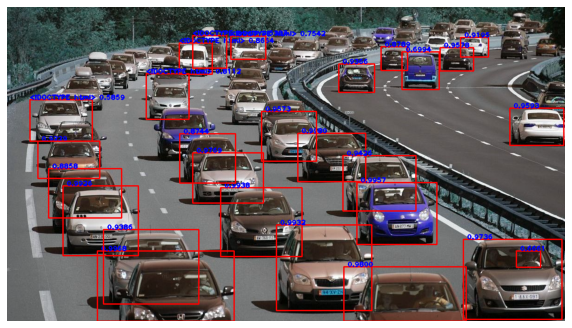

In [ ]:
plt.figure(figsize=(10, 6))
_ = plt.imshow(img)
_ = plt.axis("off")

## References

- https://www.mathworks.com/discovery/object-detection.html
- https://machinelearningspace.com/yolov3-tensorflow-2-part-4/
- https://blog.paperspace.com/how-to-implement-a-yolo-object-detector-in-pytorch/